# Galaxy Selector MOC

**Designed to work with Multi-Ordering-Sky-Maps and both burst (i.e. no distance) and normal LVK maps**



Select the galaxies to observe by WWFI in this simple manner:
- get the LIGO event data
- read the LIGO event data into the notebook, extract some information
- read the DESI database into the notebook, "clean" the data
- get the 99% credible regions for the event, add them as a column to the data
- only keep data within the 99% region
- calculate all the luminosities (& more)
- rank them by luminosity (for now just print the TARGETID), 3D/2D localization and with a luminosity-distance 2D dependant counterpart likelihood

(some) Sources: 
- https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10
- https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html
- https://emfollow.docs.ligo.org/userguide/tutorial/multiorder_skymaps.html
- https://arxiv.org/pdf/1710.05452.pdf

## Import all libraries, load GW data and DESI data and extract basic info

### imports, GW data loading

In [1]:
import numpy as np
from scipy.stats import norm
import scipy as sc
from scipy.integrate import quad


from astropy.io import fits, ascii
from astropy.table import Table, hstack
from astropy import table

import astropy_healpix as ah

from astropy.table import QTable



import psycopg2

from scipy.stats import norm

from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import Planck18, z_at_value
from astropy.coordinates import Distance, SkyCoord
from astropy import units as u

import astropy.constants as asc

import matplotlib.pyplot as plt

import requests as rq

import gasel as gs

In [337]:
# Get DESI data
print("(to get DESI data) you should run scp dgruen@perlmutter.nersc.gov:/global/homes/j/jgassert/good_z_data_BGSBright.fits /project/ls-gruen/ligodesi/")

# specify the superevent name:
superevent_name = "S230609u"

# pipeline - bayestar is preferred if available, otherwise maybe use olib? bilby? cwb? whatever these mean
pipeline_type = "bayestar"

if pipeline_type == "cwb":
    # bursts probably only for very nearby core-collapse or Andromeda events, maybe cut at 1Mpc or something of that order? -> check if there is a very nearby galaxy
        # think about which pipeline detected it!
    # or very massive bbh but then hope is that cbc would detect as well
    
    modeled_search = False
else:
    modeled_search = True

# storage directory
# storage = "/project/ls-gruen/ligodesi/"
# storage_desi_data = storage
storage = "/global/homes/j/jgassert/ligo-desi-gw-follow-up/Galaxy Selection/Files/" # Julius on NERSC
storage_desi_data = "/global/homes/j/jgassert/"

you should run scp dgruen@perlmutter.nersc.gov:/global/homes/j/jgassert/good_z_data_BGSBright.fits /project/ls-gruen/ligodesi/


In [338]:
path = storage+f"{superevent_name}{pipeline_type}.multiorder.fits,1" # 5min after alert this should be there

try:
    skymap = QTable.read(path)
    print("read skymap from local file")
    
except:
    download_url = f"https://gracedb.ligo.org/api/superevents/{superevent_name}/files/{pipeline_type}.multiorder.fits,1"
    save_path = storage+f"{superevent_name}{pipeline_type}.multiorder.fits,1"
    print("no local skymap...")
    print(f"...will download LIGO event file from superevent {superevent_name}, corresponding file URL is {download_url} and save it in .../Files/")
    
    response = rq.get(download_url, allow_redirects = True)
    print("HTTP status",response.status_code)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
            
        skymap = QTable.read(path)

no local skymap...
...will download LIGO event file from superevent S230609u, corresponding file URL is https://gracedb.ligo.org/api/superevents/S230609u/files/bayestar.multiorder.fits,1 and save it in .../Files/
HTTP status 200


Specifiy the path where the data is located and then load the data (this loads everything, just have a look)

In [339]:
skymap[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
1024,1.2244322287211873e-09,inf,1.0,0.0
1025,3.6186401822054184e-09,inf,1.0,0.0
1026,1.6473597195454547e-09,inf,1.0,0.0
1027,3.0758964347991933e-09,inf,1.0,0.0
1028,8.740285819236264e-08,inf,1.0,0.0


### Get basic values from GW event

We now extract some basic information  from the healpix data:
- ipix_max: pixel with highest likelihood
- npix: total number of pixels
- ra, dec: ra and dec of the pixel with the highest likelihood

Then we open the full fits file and extract some more basic info from the header:
- dist_mean: mean distance of the GW event
- dist_std: error of the distance

In [340]:
# most probable sky location
i = np.argmax(skymap["PROBDENSITY"])
uniq = skymap[i]["UNIQ"]
print("UNIQ ID of highest prob sky localization: ", uniq)

UNIQ ID of highest prob sky localization:  591799


In [341]:
# calculate the most probable pixel, convert to RA and dec
level_max, ipix_max = ah.uniq_to_level_ipix(uniq)
nside = ah.level_to_nside(level_max)
ra, dec = ah.healpix_to_lonlat(ipix_max, nside, order = "nested")
print("Highest probability at (RA, dec): ", ra.deg, dec.deg, "with prob [1/deg^2] of: ", skymap[i]['PROBDENSITY'].to_value(u.deg**-2), "and UNIQ ID: ", skymap[i]["UNIQ"])

Highest probability at (RA, dec):  94.5703125 -26.443334157130206 with prob [1/deg^2] of:  0.0022315359827684428 and UNIQ ID:  591799


Now open the fits file and read basics info from the header

In [342]:
if modeled_search:
    fits_gw = fits.open(path)
    header = fits_gw[1].header
    dist_mean = header["DISTMEAN"]
    dist_std = header["DISTSTD"]
    print("The dist_mean and dist_std values: ", dist_mean*u.Mpc, dist_std*u.Mpc)
    most_likely_z = z_at_value(Planck18.luminosity_distance, dist_mean*u.Mpc, zmax = 5)
    most_likely_z_std = z_at_value(Planck18.luminosity_distance, dist_std*u.Mpc, zmax = 5)
    print(f"This corresponds to the most likely z {most_likely_z} and its error {most_likely_z_std}")
else:
    print("As this is an unmodeled search there is no distance available")

The dist_mean and dist_std values:  2798.778095695261 Mpc 842.0974799542527 Mpc
This corresponds to the most likely z 0.48262211443495223 redshift and its error 0.16939643985202008 redshift


### Get DESI data

Load the full daily data from the file, which only includes good redshift objects

In [429]:
follow_up_others = False

In [430]:
if follow_up_others:
    center_ra = 235.9839
    center_dec = 15.2248
    radius = 1/360
    z_others = 0
    z_others_std = 0.4
    
    sigma_accuracy = 3
    
    data = gs.db_doall(center_ra, center_dec, radius)
    
    #ii = data["Z"]-sigma_accuracy*data["ZERR"]<z_others+sigma_accuracy*z_others_std
    #ii &= data["Z"]+sigma_accuracy*data["ZERR"]>z_others-sigma_accuracy*z_others_std
    
    #data = data[ii]
    
    
else:
    data = Table.read(storage_desi_data+"good_z_data.fits")

In [431]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
-407206628,289.160148698913,63.8756777034092,20210513,0.488143245600312,6.00460085329576e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206517,289.24523373072,64.1182126208345,20210513,0.353953432359517,9.16563620937551e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206395,288.991137990503,64.4269390406163,20210513,1.04167986703249,0.000103598417102832,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206306,288.328820102558,64.8171915439228,20210513,0.446085744563991,0.000103302897346752,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206302,288.170414727353,64.8761951861955,20210513,5.11210896599966,0.000690663180059733,0,0.0,0.0,0.0,QSO,0,0.0,0.0


## Do all the calculations, selections,...

- turn the daily DESI data into a Table
- do some basic data selection stuff: only keep good + positive redshifts, only positive values of r-band flux and eliminate duplicates (right now simply takes the first entry)
- add the ipix (healpix) pixel value for each target
- calculate the probability for each target
- add these values to the Table ("PROB"), select only targets within the 99% credible region (i.e. with a certainty of 99% the GW event is inside this region)
- calculate the distances and its errors from the redshift, add to the data table
- calculate the 3D probability just like here: https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10 (§4) and add these values to the table
- sort the table by its 3D probability (descending)
- calculate absolute and apparent magnitude, luminosity and add to table

The final step is to include the calculation of the most likely host galaxy from https://arxiv.org/pdf/1710.05452.pdf (GW170817); these values are then also added to the table as "P_GAL"

In [432]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
-407206628,289.160148698913,63.8756777034092,20210513,0.488143245600312,6.00460085329576e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206517,289.24523373072,64.1182126208345,20210513,0.353953432359517,9.16563620937551e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206395,288.991137990503,64.4269390406163,20210513,1.04167986703249,0.000103598417102832,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206306,288.328820102558,64.8171915439228,20210513,0.446085744563991,0.000103302897346752,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0
-407206302,288.170414727353,64.8761951861955,20210513,5.11210896599966,0.000690663180059733,0,0.0,0.0,0.0,QSO,0,0.0,0.0


### data clean up

In [433]:
#data = data[data["Z"]> 0]
#data = data[data["ZWARN"] == 0]

In [434]:
#data = data[data['FLUX_Z']>0]
data = table.unique(data, keys = "TARGETID")

In [435]:
data = data[data["TARGETID"]>0]

In [436]:
print(f"We have {len(data)} objects in the full catalog") 

We have 27880744 objects in the full catalog


We should also get rid of stars, since they wont be the host of a GW event

In [437]:
data = data[data["SPECTYPE"] != "STAR"]

### Calculate the healpix id for every object in the catalog and its probability; append this data to the Table

In [438]:
max_level = 29 # highest possible HEALPix resolution that can be represented in a 64-bit signed integer
max_nside = ah.level_to_nside(max_level)
level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])

index = ipix*(2**(max_level-level))**2

sorter = np.argsort(index)

# this is the NESTED pixel index of the target sky location, NOT THE UNIQ ID
match_ipix = ah.lonlat_to_healpix(data["TARGET_RA"]*u.deg, data["TARGET_DEC"]*u.deg, max_nside, order='nested')

# here we get the pixel index (i.e. where the entry is in the table, also NOT THE UNIQ ID) of each target
sorter_i = sorter[np.searchsorted(index, match_ipix, side='right', sorter=sorter) - 1]
probdensity = skymap[sorter_i]['PROBDENSITY'].to_value(u.deg**-2)

# now we calculate the UNIQ ID for all our targets:

uniq = skymap["UNIQ"][sorter_i]
#to make things easier in future, I will now also append the UNIQ pixels DISTMU, DISTSIGMA and DISTNORM values. However, be careful, since these DO NOT CORRESPOND THE TARGETS IN DESI DIRECTLY!

if modeled_search:
    distmu = skymap[sorter_i]["DISTMU"]
    distsigma = skymap[sorter_i]["DISTSIGMA"]
    distnorm = skymap[sorter_i]["DISTNORM"]


In [439]:
# len(UNIQ), len(data), len(skymap)

In [440]:
#data = data.keep_columns(["TARGETID", "TARGET_RA", "TARGET_DEC", "TILEID", "NIGHT", "Z", "ZERR", "ZWARN", "DELTACHI2", "FLUX_Z", "BGS_TARGET", "EBV", "SERSIC", "MWS_TARGET", "FILENAME"])
                          

In [441]:
if modeled_search:
    data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity}), Table({"DISTMU": distmu}), Table({"DISTSIGMA": distsigma}), Table({"DISTNORM": distnorm})])
else: 
    data = hstack([data, Table({"UNIQ": uniq}), Table({"PROBDENSITY": probdensity})])
    print(f"The table will not contain any distance info since there is none available")

In [442]:
data[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64
6448025174016,179.15657,28.4234799,20210318,0.0221933367215889,9.68081653157043e-06,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,2803,3.048194174452861e-14,2954.3221516121816,1809.2459608283675,8.369212343064796e-08
6521555517440,204.22749,32.09493,20210404,0.3238872170838,2.72909868562699e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,1676,2.2923452966039407e-12,-1125.9343624438945,2850.8124601195805,4.830243160208085e-07
6536638234624,186.274119,32.84503,20210402,0.0764062738003505,1.47657330826664e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,2807,2.0782752875347166e-14,4118.812017239321,1562.6655174688085,5.153393470040171e-08
45803351579259,198.2176891,18.3113961,20210316,1.49911242224797,3.38509589473939e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,2773,1.9980899316906909e-10,inf,1.0,0.0
46523089944591,258.5210502,56.1317935,20210409,1.62639091480193,0.000120044446065552,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,6641,1.9620568525875646e-08,3165.9826341019275,1274.667359546746,8.586516872843094e-08


In [443]:
print(f"The highest and lowest probability values in our catalog are: {np.max(probdensity)} and {np.min(probdensity)}")

The highest and lowest probability values in our catalog are: 0.0019891805592143867 and 1.2077099785747572e-14


### Sort the skymap table and get 99% credible region

In [444]:
# copy the table
skymap_sort = Table(skymap, copy = True)

In [445]:
# check whether copy worked:
# skymap_sort, skymap
# np.max(skymap["UNIQ"])

In [446]:
# now sort the skymap by its probability (descending)
skymap_sort.sort('PROBDENSITY', reverse=True)

In [447]:
# this shows the first entries sorted be their probability
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,1 / sr,Mpc,Mpc,1 / Mpc2
int64,float64,float64,float64,float64
591799,7.32570049451194,2585.854049788445,868.376535587565,1.343986259209612e-07
591720,7.322245127712063,2581.3237238018223,866.8585064360851,1.348706847183906e-07
591714,7.321790677355392,2580.432592049214,866.5527920745982,1.3496405731183445e-07
591722,7.321074055888819,2582.188045927099,867.1542885907996,1.347802368851216e-07
591805,7.321022361944126,2586.4989247911353,868.5961126779994,1.3433152238027153e-07


In [448]:
# now get 99% credible region area

level, ipix = ah.uniq_to_level_ipix(skymap_sort['UNIQ'])
pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level)) # this is the area each pixel contains

# calculate the probability per pixel (careful: since the pixels differ in size, this is not neceseraliy a useful quantity
prob = pixel_area * skymap_sort['PROBDENSITY']

# calc cumsum of probabilities and get index of pixel that sums up to 0.99
cumprob = np.cumsum(prob)
i = cumprob.searchsorted(0.99)

# print area
area_99 = pixel_area[:i].sum()
area_99_deg = area_99.to_value(u.deg**2)
print(f"The 99% search area is {area_99_deg}°large")

The 99% search area is 4236.754321025971°large


### can be deleted, just tried things out

In [449]:
skymap_sort = hstack([skymap_sort, Table({"PROB": prob})])

In [450]:
np.max(prob)

<Quantity 0.00013462>

In [451]:
skymap_sort[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
591799,7.32570049451194,2585.854049788445,868.376535587565,1.343986259209612e-07,0.00011705712308735059
591720,7.322245127712063,2581.3237238018223,866.8585064360851,1.348706847183906e-07,0.00011700190989687028
591714,7.321790677355392,2580.432592049214,866.5527920745982,1.3496405731183445e-07,0.00011699464824982673
591722,7.321074055888819,2582.188045927099,867.1542885907996,1.347802368851216e-07,0.00011698319737939018
591805,7.321022361944126,2586.4989247911353,868.5961126779994,1.3433152238027153e-07,0.00011698237136357758


In [452]:
skymap_prob = Table(skymap_sort, copy = True)

In [453]:
skymap_prob.sort("PROB", reverse = True)

In [454]:
skymap_prob[:5]

UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,PROB
,1 / sr,Mpc,Mpc,1 / Mpc2,
int64,float64,float64,float64,float64,float64
4309,0.13163420015961974,929.4620081637144,280.59356116928063,1.060864309106485e-06,0.00013461622271569978
222700,2.105982273445538,2257.961348233943,714.0780602846145,1.7830902379381402e-07,0.00013460568112888248
9955,0.1315128565622241,1939.199393454237,624.993170502434,2.4090249925048983e-07,0.0001344921302176079
37263,0.5260195386008715,2606.2763503262495,902.541810358333,1.3145775050999627e-07,0.00013448397771103436
16758,0.5260169818588811,1293.4932069371093,459.3029379151513,5.307857131437124e-07,0.0001344833240455189


### Compare Tables, only leave 99% credible region in DESI data table

Now we can get a Table that only contains the 99% credible region. From there we only leave the matching objects in the DESI data

In [455]:
# we simply select only the entries that are within the 99% credible region
skymap_99 = skymap_sort[:i]

In [456]:
print("This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID):", len(np.intersect1d(skymap_99["UNIQ"], data["UNIQ"])))

This is the number of UNIQ ID of objects which should lie within the 99% credible region (NOT THE NUMBER OF OBJECTS, as there can be multiple objects per UNIQ ID): 2904


In [457]:
mask = np.in1d(data["UNIQ"], skymap_99["UNIQ"])
data_99 = data[mask]

In [458]:
print(f"We now have {len(data_99)} objects in the 99% credible region")
print("Check if the region from where the galaxies have been selected makes any sense (RA; DEC): ", np.min(data_99["TARGET_RA"]), np.max(data_99["TARGET_RA"]), np.min(data_99["TARGET_DEC"]), np.max(data_99["TARGET_DEC"]))

max_probdens_in_desi = np.max(data_99["PROBDENSITY"])
max_probdens_in_ligo = np.max(skymap["PROBDENSITY"]).to_value(u.deg**-2)
print(f"We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...")
print(f"This is {np.allclose(max_probdens_in_desi, max_probdens_in_ligo)}")

We now have 2329917 objects in the 99% credible region
Check if the region from where the galaxies have been selected makes any sense (RA; DEC):  17.00491913272 285.588539333929 -21.9997270654372 81.5410802135118
We can also check whether we have at least one galaxy in the UNIQ pixel with the highest probability from LIGO...
This is False


In [459]:
data_99.sort('PROBDENSITY', reverse=True)

In [460]:
data_99[:2]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64
39627329441367512,87.0214831261028,-19.3159172815501,20210107,0.405551670647463,3.44483765499101e-05,0,1.73643779754639,6.23603582382202,13.1384925842285,GALAXY,0,0.0637876316905022,1.0,599488,0.0019891805592143867,2562.9822109730985,861.3009065740661,1.367885805870855e-07
39627318037056833,87.0551075993945,-19.6428138784943,20210107,0.268409679624286,1.51862890830181e-05,0,3.05206036567688,7.90451812744141,15.2817258834839,GALAXY,0,0.0581257492303848,1.0,599359,0.00197831813706484,2567.62032815077,862.9638209307491,1.3629150317579056e-07


In [461]:
if modeled_search:
    print("We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky")
    min_z = np.min(data_99["Z"])
    max_z = np.max(data_99["Z"])
    print(f"However, we have not used the distance data at all. Therefore our redshifts range from {min_z} to {max_z}")
else:
    print(f"Usually we would be performing steps to cut out objects that don't meet the z-range/distance from LIGO, since there is no distance, we - at least for now include everything!")

We have now performed all the necessary steps to get the localization selection in 2D, i.e. the angle on the sky
However, we have not used the distance data at all. Therefore our redshifts range from 5.31004411037158e-09 to 6.68597850286256


### Calculate all the distances of the objects from the redshifts

We want to be conservative in estimating the distance from redshifts, therefore we will include different cosmologies.

Our cosmologies include:
- H0 = 68.20 ± 0.81 km s−1Mpc−1, from eBOSS https://arxiv.org/pdf/2007.08991.pdf
- DES Y3 https://arxiv.org/abs/2105.13549
- SH0ES https://pantheonplussh0es.github.io/

Now we calculate the arithmetic mean of our distances and its standard deviation:
$$distances_{mean} = \frac{dist(z_{cosmo_{max}})+dist(z_{cosmo_{min}})}{2}$$
and accordingly the standard deviation (n=2):
$$\sigma = \sqrt{\frac{1}{n-1}\sum\left(dist_i-distances_{mean}\right)^2}$$


In [462]:
#distances = Distance(z=data_99["Z"], cosmology=Planck18)
#distances_err = Distance(z=data_99["ZERR"], cosmology=Planck18)

In [463]:
if modeled_search:
    # first define the cosmological maximum and minimum parameters
    omega_M_max = 0.339+0.032 #(from DES)
    omega_M_min = 0.299-2*0.016 #from eBOSS

    H_0_max = 73.04+2*1.04 #from SH0ES
    H_0_min = 67.4-2*0.5 #from Planck
    
    # then calculate min and max luminosity distance from the redshifts
    cosmo_min_dist = FlatLambdaCDM(H0=H_0_max, Om0=omega_M_max)
    cosmo_max_dist = FlatLambdaCDM(H0=H_0_min, Om0=omega_M_min)

    dists_max = Distance(z=data_99["Z"], cosmology=cosmo_max_dist)
    dists_min = Distance(z=data_99["Z"], cosmology=cosmo_min_dist)
    
    # and of course also calculate the maximum and minimum error from the redshfit uncertainty
    dists_err_min = Distance(z=data_99["ZERR"], cosmology=cosmo_max_dist)
    dists_err_max = Distance(z=data_99["ZERR"], cosmology=cosmo_min_dist)
    
    # now we get the mean distance and its error
    dists_mean = (dists_max+dists_min)/2
    dists_err_mean = (dists_err_max+dists_err_min)/2  # this is our sigma for the redshift error
    
    # calculate the stdev of the distance depending on the cosmology
    dists_mean_stddev = np.sqrt((dists_max-dists_mean)**2+(dists_min-dists_mean)**2)
    
    # now stack all the data
    data_99 = hstack([data_99, Table({"DIST_Z_MEAN": dists_mean}), Table({"DIST_Z_ERR": dists_err_mean}), Table({"DIST_Z_COSMO_SIGMA": dists_mean_stddev})])

In [464]:
# dists_mean[:5], dists_mean_stddev[:5], dists_mean_stddev[:5]/dists_mean[:5], np.mean(dists_mean_stddev/dists_mean), np.max(dists_mean_stddev/dists_mean), np.min(dists_mean_stddev/dists_mean)


In [465]:
data_99[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
39627329441367512,87.0214831261028,-19.3159172815501,20210107,0.405551670647463,3.44483765499101e-05,0,1.73643779754639,6.23603582382202,13.1384925842285,GALAXY,0,0.0637876316905022,1.0,599488,0.0019891805592143867,2562.9822109730985,861.3009065740661,1.367885805870855e-07,2183.492406350188,0.14650925004373436,235.56300720926782
39627318037056833,87.0551075993945,-19.6428138784943,20210107,0.268409679624286,1.51862890830181e-05,0,3.05206036567688,7.90451812744141,15.2817258834839,GALAXY,0,0.0581257492303848,1.0,599359,0.00197831813706484,2567.62032815077,862.9638209307491,1.3629150317579056e-07,1353.0555272199908,0.06458647235400179,137.11573399046333
616088070340477851,87.1183808319715,-19.680166475756,20210206,0.508388753086125,6.23261576343437e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,599359,0.00197831813706484,2567.62032815077,862.9638209307491,1.3629150317579056e-07,2856.015230051721,0.26507933858103094,320.9869191686455
39627318037057219,87.066255739702,-19.6587108421125,20210206,1.45256609927591,3.05799472908312e-05,0,0.453402727842331,0.579267501831055,0.872416198253632,GALAXY,0,0.0574152544140816,1.0,599359,0.00197831813706484,2567.62032815077,862.9638209307491,1.3629150317579056e-07,10320.524636492057,0.1300564022740129,1438.2573981007924
616088076036342006,87.0852247595879,-19.576043033542,20210107,1.48880514438833,7.76971202034664e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,599359,0.00197831813706484,2567.62032815077,862.9638209307491,1.3629150317579056e-07,10638.485010885372,0.33045744498575413,1489.472940889187


### Lets check how much the distance measurement changes in the 99% credible region of LIGO and compare to our DESI data

We should see a lot more data in DESI (since we haven't done any redshift selection and there can be multiple objects per GW-pixel). Be carfeul, we are comparing actual object counts with the number of pixels.


We still see, that most of the GW localization is roughly between 780Mpc and 950Mpc. DESI definitely has a most of its data in this range as well.

Our LIGO distances range from 593.0855608959163 Mpc to 2868.558092298574 Mpc
Let's visualize the distance distribution of the LIGO event in the 99% credible region


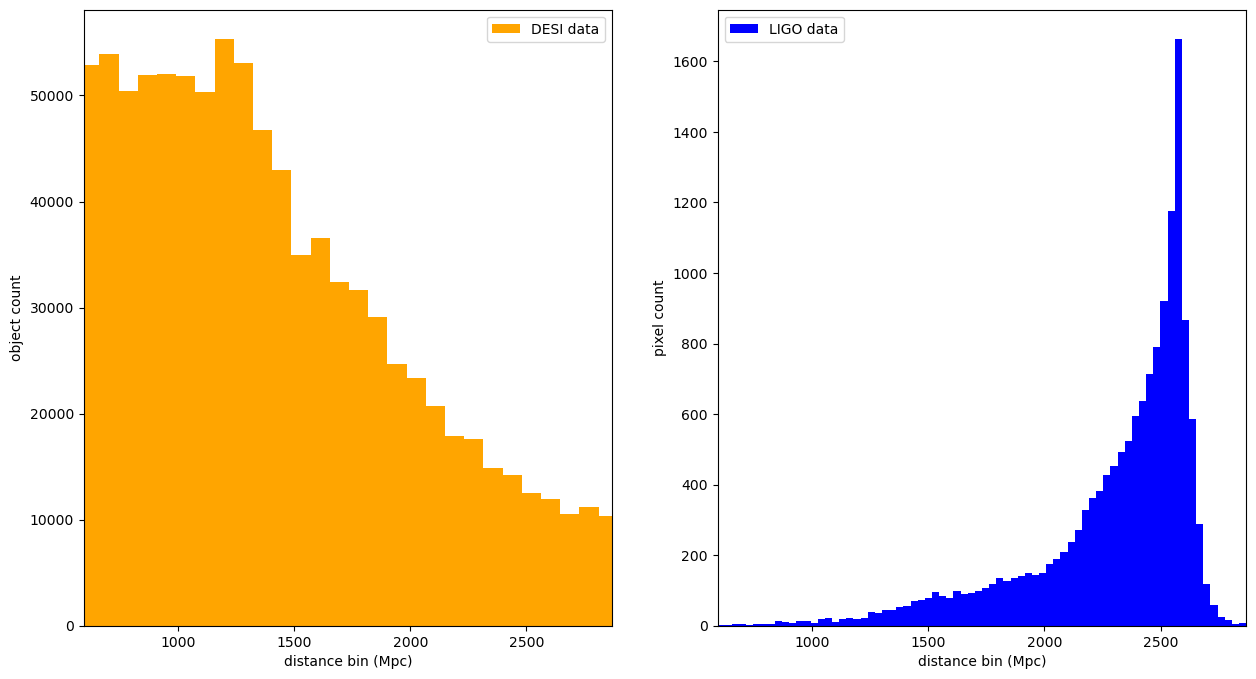

In [466]:
if modeled_search:
    plt_skymap = skymap_99[skymap_99["DISTMU"]<np.inf]

    dist_max_99 = np.max(plt_skymap["DISTMU"])*u.Mpc
    dist_min_99 = np.min(plt_skymap["DISTMU"])*u.Mpc
    print(f"Our LIGO distances range from {dist_min_99} to {dist_max_99}")
    print("Let's visualize the distance distribution of the LIGO event in the 99% credible region")

    fig, ax = plt.subplots(ncols = 2, figsize = (15,8))


    ax[0].hist(data_99["DIST_Z_MEAN"], bins = "auto", color = "orange", label = "DESI data")
    ax[1].hist(plt_skymap["DISTMU"], bins = "auto", color = "blue", label = "LIGO data")


    for axis in ax:
        axis.set_xlabel("distance bin (Mpc)")
        axis.set_xlim(dist_min_99/u.Mpc, dist_max_99/u.Mpc)
        axis.legend()

    ax[0].set_ylabel("object count")
    ax[1].set_ylabel("pixel count")

    plt.show()

In [467]:
len(skymap_99), len(data_99)

(15086, 2329917)

### To reduce our data even more, lets cut out the unreasonably far away objects

We simply take maximum and minimum distance we get from the LIGO skymap (i.e. DISTMU+-DISTERR) and check, whether every galaxy in that pixel falls inside this range.

*Note: We do this only for our own GW-follow ups*

In [468]:
if follow_up_others == False and modeled_search == True:
    z_selection_mask = data_99["DIST_Z_MEAN"] - 2*data_99["DIST_Z_ERR"] - 2*data_99["DIST_Z_COSMO_SIGMA"] <  data_99["DISTMU"] + 2*data_99["DISTSIGMA"]
    z_selection_mask &= data_99["DIST_Z_MEAN"] + 2*data_99["DIST_Z_ERR"] + 2*data_99["DIST_Z_COSMO_SIGMA"] >  data_99["DISTMU"] - 2*data_99["DISTSIGMA"]

    data_99_z = data_99[z_selection_mask]

    remaining_obj = np.size(np.where(z_selection_mask == True))
    deleted_obj = np.size(np.where(z_selection_mask == False))

    print(f"The z-range selection has deleted {deleted_obj} objects from originally {deleted_obj+remaining_obj} in the data set")
    print(f"Therefore, we have {remaining_obj} objects left in the search region")

    highest_prob_dens = np.max(data_99_z["PROBDENSITY"])
    print(f"Our highest remaing probability density is {highest_prob_dens} compared to the originally highest prob density of {max_probdens_in_ligo}")
    print(f"The difference in prob density is {max_probdens_in_ligo-highest_prob_dens}")

    
else:
    data_99_z = data_99
    remaining_obj = len(data_99_z)

The z-range selection has deleted 1733480 objects from originally 2329917 in the data set
Therefore, we have 596437 objects left in the search region
Our highest remaing probability density is 0.0019891805592143867 compared to the originally highest prob density of 0.0022315359827684428
The difference in prob density is 0.00024235542355405607


In [469]:
data_99_z[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
39627329441367512,87.0214831261028,-19.3159172815501,20210107,0.405551670647463,3.44483765499101e-05,0,1.73643779754639,6.23603582382202,13.1384925842285,GALAXY,0,0.0637876316905022,1.0,599488,0.0019891805592143867,2562.9822109730985,861.3009065740661,1.367885805870855e-07,2183.492406350188,0.14650925004373436,235.56300720926782
616088070340477851,87.1183808319715,-19.680166475756,20210206,0.508388753086125,6.23261576343437e-05,0,0.0,0.0,0.0,GALAXY,0,0.0,0.0,599359,0.00197831813706484,2567.62032815077,862.9638209307491,1.3629150317579056e-07,2856.015230051721,0.26507933858103094,320.9869191686455
39627329437177493,86.9323141087831,-19.1704331266067,20210107,0.356280695109085,1.24449339129845e-05,0,3.78639912605286,10.0700845718384,19.1833915710449,GALAXY,0,0.0658317059278488,1.0,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,1875.8393618928155,0.052927525231635686,198.08904858563852
39627329441367651,87.0258454971578,-19.283549087624,20210107,0.403222031933717,2.14880628477579e-05,0,2.50455784797668,8.54479694366455,18.5866603851318,GALAXY,0,0.0637028589844704,0.665353775024414,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,2168.723975306241,0.09138801742114039,233.73947343007
39627329441366288,86.9714440576614,-19.2272898194948,20210107,0.372820207766997,4.60867072100309e-05,0,2.09091639518738,6.80626535415649,13.8271465301514,GALAXY,0,0.0646747946739197,0.677806317806244,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,1978.0010649916294,0.19600891405307036,210.410878632549


### get the apparent, absolute magnitudes and luminosities

in order to do this: flux > 0 selection  and gal ext correction

In [470]:
# get the apparent mags
orig_len = len(data_99_z)
data_99_z = data_99_z[data_99_z["FLUX_R"] > 0] # flux selection (only ones above 0)
print(f"had to cut out {len(data_99_z)-orig_len} objects due to bad fluxes")
data_99_z["MW_TRANSMISSION"] = gs.mw_transmission_from_data_table(data = data_99_z, band = "r")
#data_99_z["FLUX_R"] = data_99_z["FLUX_R"]/data_99_z["MW_TRANSMISSION"]

app_mag_r = gs.app_mag(data_99_z["FLUX_R"], mw_transmission = data_99_z["MW_TRANSMISSION"])
flux_selection_cut = len(data_99_z)

# get the absolute mags
abs_mag_r = gs.abs_mag(app_mag_r, data_99_z["Z"], 0,0,0)

# get the luminosities
lums_r = gs.lum(abs_mag_r, band = "r")

had to cut out -14347 objects due to bad fluxes


In [471]:
data_f = hstack([data_99_z, Table({"APP_MAG_R": app_mag_r}), Table({"ABS_MAG_R": abs_mag_r}), Table({"LUM_R": lums_r})])

In [472]:
data_f[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA,MW_TRANSMISSION,APP_MAG_R,ABS_MAG_R,LUM_R
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc,,,,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39627329441367512,87.0214831261028,-19.3159172815501,20210107,0.405551670647463,3.44483765499101e-05,0,1.73643779754639,6.23603582382202,13.1384925842285,GALAXY,0,0.0637876316905022,1.0,599488,0.0019891805592143867,2562.9822109730985,861.3009065740661,1.367885805870855e-07,2183.492406350188,0.14650925004373436,235.56300720926782,0.8806136764160551,20.374692061541026,-21.411984082695106,1.9798276978731544e+36
39627329437177493,86.9323141087831,-19.1704331266067,20210107,0.356280695109085,1.24449339129845e-05,0,3.78639912605286,10.0700845718384,19.1833915710449,GALAXY,0,0.0658317059278488,1.0,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,1875.8393618928155,0.052927525231635686,198.08904858563852,0.8770332838058498,19.849957393584784,-21.60682153415652,2.3689853572179725e+36
39627329441367651,87.0258454971578,-19.283549087624,20210107,0.403222031933717,2.14880628477579e-05,0,2.50455784797668,8.54479694366455,18.5866603851318,GALAXY,0,0.0637028589844704,0.665353775024414,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,2168.723975306241,0.09138801742114039,233.73947343007,0.8807624792146085,20.032892646362356,-21.739041528844915,2.6757798208226047e+36
39627329441366288,86.9714440576614,-19.2272898194948,20210107,0.372820207766997,4.60867072100309e-05,0,2.09091639518738,6.80626535415649,13.8271465301514,GALAXY,0,0.0646747946739197,0.677806317806244,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,1978.0010649916294,0.19600891405307036,210.410878632549,0.8790579333728415,20.2777715522765,-21.294204010335665,1.7762961185637535e+36
39627323732920603,86.9037933972536,-19.508210698781,20210107,0.598456896845099,6.21925476077341e-05,0,1.11535751819611,6.6240758895874,25.0407218933105,GALAXY,0,0.05992316827178,6.0,599445,0.0019636417514989116,2566.7812080767403,862.7688889284643,1.3637783842421925e-07,3475.569075569475,0.2645110549025907,403.31932197732635,0.8874226425853272,20.317513015468442,-22.478770843168952,5.288616796151136e+36


### Check the absolute and apparent magnitudes

This is a sanity check to quickly check whether there might be some obvious problem in the data/derivation of magnitudes...

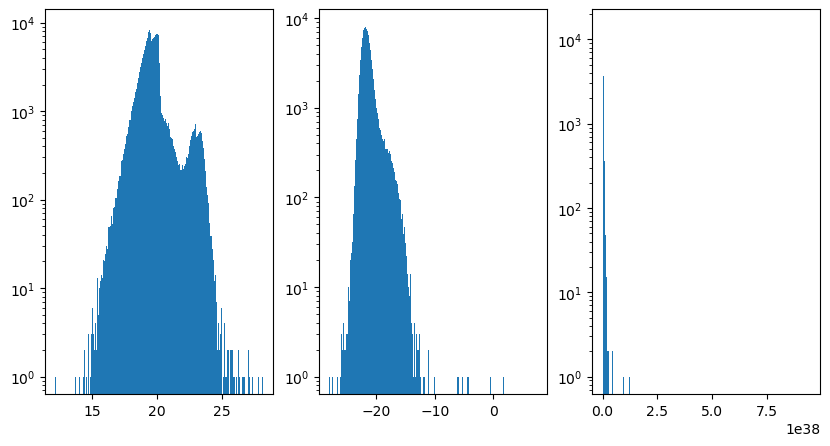

In [473]:
if len(data_f) < 1000000:
    # dauert sonst einfach ewig
    fig, ax = plt.subplots(ncols = 3, figsize=(10,5))

    plot_names = ["APP_MAG_R", "ABS_MAG_R", "LUM_R"]
    cnt = 0
    for axis in ax:
        axis.hist(data_f[plot_names[cnt]], bins = "auto")
        axis.set_yscale("log")
        cnt += 1
    plt.show()

These objects have a mean redshift of 0.005803846281070924, which corresponds to a mean distance of 25.200380589298565 Mpc
The minimum redshift is 3.82229586945523e-06, i.e. 0.01625587819507659 Mpc
According to WolframAlpha the closest galaxy has a distance of roughly 25000ly = 7655pc (not Mpc, simply pc), so any object below 0.07Mpc is definitely not a real galaxy
This reminded me to check if we have selected galaxies only...
We have 0 stars in our catalogue of peculiar objects, compared to a total number of 82 objects...


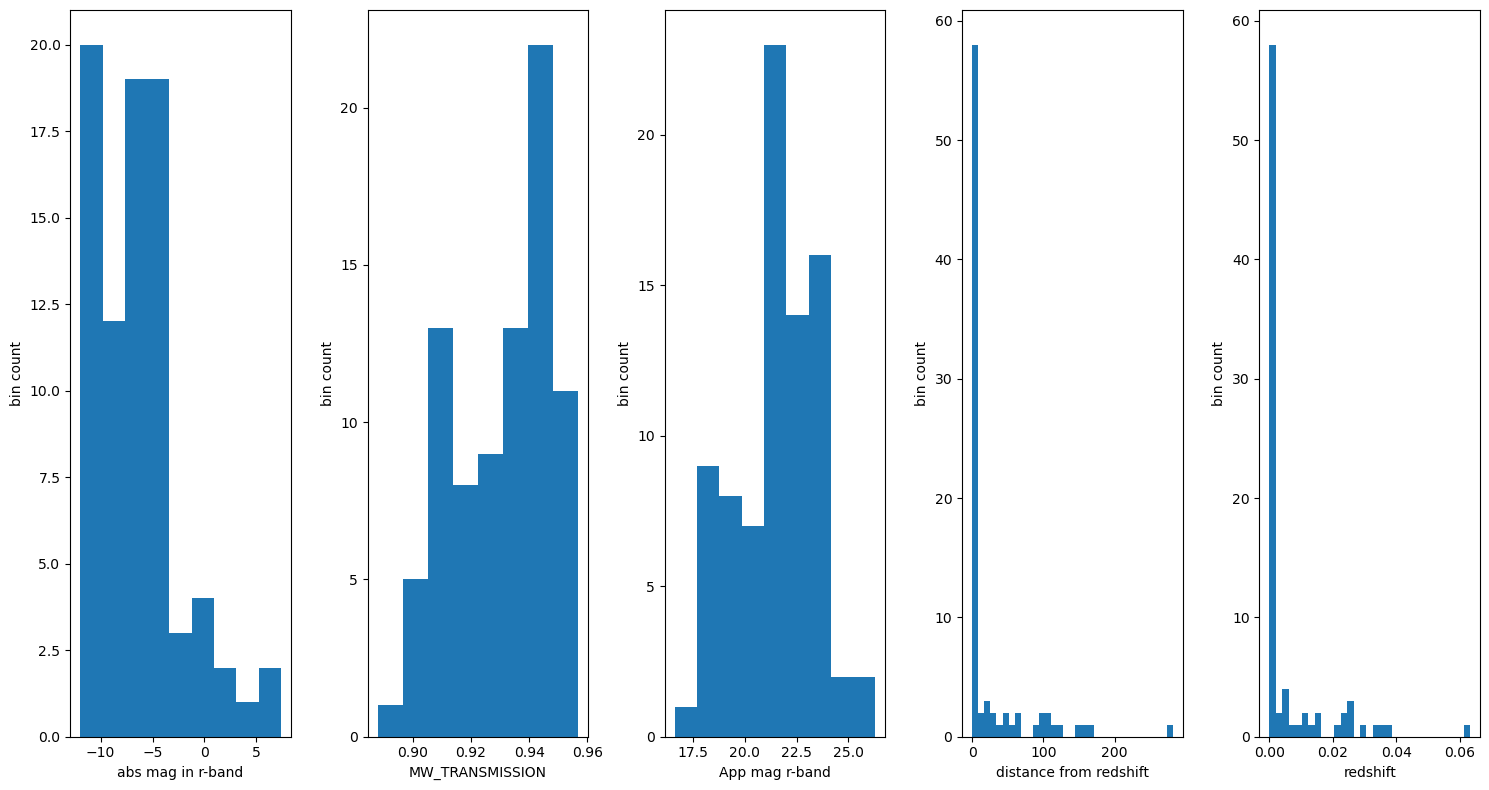

In [507]:
inspect_abs_mags = True

if inspect_abs_mags:
    data_to_inspect = data_f[data_f["ABS_MAG_R"]> -12]
    fig, ax = plt.subplots(ncols = 5, figsize = (15,8))
    
    ax[0].hist(data_to_inspect["ABS_MAG_R"], bins = "auto")
    ax[0].set_xlabel("abs mag in r-band")
    ax[1].hist(data_to_inspect["MW_TRANSMISSION"], bins = "auto")
    ax[1].set_xlabel("MW_TRANSMISSION")
    ax[2].hist(data_to_inspect["APP_MAG_R"], bins = "auto")
    ax[2].set_xlabel("App mag r-band")
    ax[3].hist(data_to_inspect["DIST_Z_MEAN"], bins = "auto")
    ax[3].set_xlabel("distance from redshift")
    ax[4].hist(data_to_inspect["Z"], bins = "auto")
    ax[4].set_xlabel("redshift")
    
    mean_redshift_pec_objects = np.mean(data_to_inspect["Z"])
    mean_distance_pec_objects = np.mean(data_to_inspect["DIST_Z_MEAN"])*u.Mpc
    min_redshift_pec_objects = np.min(data_to_inspect["Z"])
    min_distance_pec_objects = np.min(data_to_inspect["DIST_Z_MEAN"])*u.Mpc
    
    data_to_inspect_len = len(data_to_inspect)
    star_data_len = len(data_to_inspect[data_to_inspect["SPECTYPE"] == "STAR"])
    
    print(f"These objects have a mean redshift of {mean_redshift_pec_objects}, which corresponds to a mean distance of {mean_distance_pec_objects}")
    print(f"The minimum redshift is {min_redshift_pec_objects}, i.e. {min_distance_pec_objects}")
    print(f"According to WolframAlpha the closest galaxy has a distance of roughly 25000ly = 7655pc (not Mpc, simply pc), so any object below 0.07Mpc is definitely not a real galaxy")
    print(f"This reminded me to check if we have selected galaxies only...")
    print(f"We have {star_data_len} stars in our catalogue of peculiar objects, compared to a total number of {data_to_inspect_len} objects...")
                        
    for axis in ax:
        axis.set_ylabel("bin count")
        #axis.legend()
        
    plt.tight_layout()
    plt.show()
    

In [475]:
# np.max(data_f["MW_TRANSMISSION"])

### start calculating the P_Gal (the probability that galaxy X is the host)

In [476]:
max_lum_r = np.max(data_f["LUM_R"])*u.W
prob_dens_max_lum = data_f[data_f["LUM_R"] == max_lum_r]["PROBDENSITY"]
print(f"The maximum luminosity in our catalog in the r-band is {max_lum_r} with a prob density of {prob_dens_max_lum}")

The maximum luminosity in our catalog in the r-band is 9.457010998480101e+38 W with a prob density of      PROBDENSITY     
---------------------
6.223522337811908e-05


In [477]:
if modeled_search:

    arg_errfc = abs(data_f["DIST_Z_MEAN"]-data_f["DISTMU"])/(data_f["DIST_Z_ERR"]**2+data_f["DISTSIGMA"]**2+data_f["DIST_Z_COSMO_SIGMA"].value**2)
    P_gal_unnorm = data_f["LUM_R"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc))
    #dist_mean*u.Mpc, dist_std*u.Mpc
    arg_errfc_c = abs(data_f["DIST_Z_MEAN"].value-dist_mean)/(data_f["DIST_Z_ERR"].value**2+dist_std**2+data_f["DIST_Z_COSMO_SIGMA"].value**2)
    P_gal_unnorm_const = data_f["LUM_R"]*data_f["PROBDENSITY"]*(1-sc.special.erf(arg_errfc_c))

    # now lets quickly normalize

    P_gal_sum = np.sum(P_gal_unnorm)
    P_gal_const_sum = np.sum(P_gal_unnorm_const)

    P_gal = 1/P_gal_sum * P_gal_unnorm
    P_gal_const = 1/P_gal_const_sum * P_gal_unnorm_const

else:
    P_gal_unnorm = data_f["LUM_R"]*data_f["PROBDENSITY"]
    P_gal_sum = np.sum(P_gal_unnorm)
    P_gal = 1/P_gal_sum * P_gal_unnorm

### Get the missed fraction of DESI due to mass/luminosity incompleteness

$$f_{missed} =  \frac{\int_{-\infty}^{\infty} dm 10^{-0.4m}\left(1-\frac{Hist}{Schechter}\right)\cdot Schechter}{\int_{-\infty}^{\infty}dm 10^{-0.4m}\cdot Schechter}$$

We want to account for the fact that some region were covered in more detail by DESI than others...

-28.109800328602574, 7.367272922638271, 0.01625587819507659 Mpc, 4408.59945542783 Mpc, 4408583199.549636


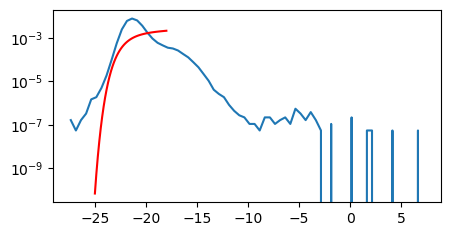

In [478]:
if modeled_search:

    # get the Schechter model, see 1/V estimator, bin size of half a mag
    from astropy.modeling.models import Schechter1D

    phi_star = 0.0017411666759990893
    m_star = -21.938911723873762
    alpha = -1.0776969153907823

    schechter_model = Schechter1D(phi_star, m_star, alpha)
    
    data_min_dist = np.min(data_f["DIST_Z_MEAN"])*u.Mpc
    data_max_dist = np.max(data_f["DIST_Z_MEAN"])*u.Mpc
    
    abs_mag_max = np.max(data_f["ABS_MAG_R"])
    abs_mag_min = np.min(data_f["ABS_MAG_R"])

    bins = np.arange(abs_mag_min, abs_mag_max, 0.5)

    hist, bins = np.histogram(data_f["ABS_MAG_R"], bins =  bins)
    hist = hist/(area_99.to_value(u.deg**2)*(data_max_dist-data_min_dist).value*10**0) # completely wrong normalization
    
    print(f"{abs_mag_min}, {abs_mag_max}, {data_min_dist}, {data_max_dist}, {(data_max_dist-data_min_dist).value*10**6}")
    
    fig, ax = plt.subplots(figsize = (5,2.5))
    bins_center = bins[1:]-(bins[1]-bins[2])/2
    ax.plot(bins_center, hist, label = "wrongly normalized distribution")
    ax.plot(np.linspace(-25,-18), schechter_model(np.linspace(-25,-18)),  label = "some schechter fit", color = "red")

    ax.set_yscale("log")
    plt.show()

In [479]:
if modeled_search:
    def hist_func(M):
        # https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
        # make sure array is a numpy array
        # array = np.array(array)
        idx = (np.abs(hist - M)).argmin()
        val = hist[idx]
        #print(f"val {val}")
        return val

    def num_func(M):
        #print(f"M is {M}")
        schechter_val = schechter_model(M)
        #print(f"schechter Val: {schechter_val}")
        lum_factor = 10**(-0.4*M)
        #print(f"lum factor {lum_factor}")
        weighting_coverage = (1-hist_func(M)/(schechter_val))
        #print(f"weighting_coverage: {weighting_coverage}")
        final_val = lum_factor*weighting_coverage*schechter_val
        #print(f"final value: {final_val}")
        return final_val
    def denom_func(M):
        lum_factor = 10**(-0.4*M)
        schechter_val = schechter_model(M)
        final_val = lum_factor*schechter_val

        return final_val




    numerator = quad(num_func, -28, -18)
    denominator = quad(denom_func, -28, -18)

    print(numerator)
    print(denominator)

    f_missed = numerator[0]/denominator[0]

    print(f_missed)

(1052592.2749107545, 0.0003165349709348675)
(1052592.2749107545, 0.0003165349709348675)
1.0


In [480]:
data_f = hstack([data_f, Table({"P_GAL": P_gal.value})])

In [481]:
data_f[:]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,UNIQ,PROBDENSITY,DISTMU,DISTSIGMA,DISTNORM,DIST_Z_MEAN,DIST_Z_ERR,DIST_Z_COSMO_SIGMA,MW_TRANSMISSION,APP_MAG_R,ABS_MAG_R,LUM_R,P_GAL
,,,,,,,,,,,,,,,,Mpc,Mpc,1 / Mpc2,Mpc,Mpc,Mpc,,,,W,
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39627329441367512,87.0214831261028,-19.3159172815501,20210107,0.405551670647463,3.44483765499101e-05,0,1.73643779754639,6.23603582382202,13.1384925842285,GALAXY,0,0.0637876316905022,1.0,599488,0.0019891805592143867,2562.9822109730985,861.3009065740661,1.367885805870855e-07,2183.492406350188,0.14650925004373436,235.56300720926782,0.8806136764160551,20.374692061541026,-21.411984082695106,1.9798276978731544e+36,2.327992127280143e-05
39627329437177493,86.9323141087831,-19.1704331266067,20210107,0.356280695109085,1.24449339129845e-05,0,3.78639912605286,10.0700845718384,19.1833915710449,GALAXY,0,0.0658317059278488,1.0,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,1875.8393618928155,0.052927525231635686,198.08904858563852,0.8770332838058498,19.849957393584784,-21.60682153415652,2.3689853572179725e+36,2.7660604223543337e-05
39627329441367651,87.0258454971578,-19.283549087624,20210107,0.403222031933717,2.14880628477579e-05,0,2.50455784797668,8.54479694366455,18.5866603851318,GALAXY,0,0.0637028589844704,0.665353775024414,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,2168.723975306241,0.09138801742114039,233.73947343007,0.8807624792146085,20.032892646362356,-21.739041528844915,2.6757798208226047e+36,3.1256361943934886e-05
39627329441366288,86.9714440576614,-19.2272898194948,20210107,0.372820207766997,4.60867072100309e-05,0,2.09091639518738,6.80626535415649,13.8271465301514,GALAXY,0,0.0646747946739197,0.677806317806244,599490,0.00197613698587998,2562.07303121524,861.0789197986969,1.3688298780261502e-07,1978.0010649916294,0.19600891405307036,210.410878632549,0.8790579333728415,20.2777715522765,-21.294204010335665,1.7762961185637535e+36,2.074345962391112e-05
39627323732920603,86.9037933972536,-19.508210698781,20210107,0.598456896845099,6.21925476077341e-05,0,1.11535751819611,6.6240758895874,25.0407218933105,GALAXY,0,0.05992316827178,6.0,599445,0.0019636417514989116,2566.7812080767403,862.7688889284643,1.3637783842421925e-07,3475.569075569475,0.2645110549025907,403.31932197732635,0.8874226425853272,20.317513015468442,-22.478770843168952,5.288616796151136e+36,6.135165638961945e-05
39627323732921413,86.9318969673453,-19.5073393234705,20210107,0.523618923576222,0.000106715513828015,0,2.77214670181274,9.32881450653076,19.5623760223389,GALAXY,0,0.0598355568945408,2.83805012702942,599445,0.0019636417514989116,2566.7812080767403,862.7688889284643,1.3637783842421925e-07,2958.8735229256426,0.45388705279319863,334.43222659839194,0.8875776176649666,19.945949710675826,-22.50078180529662,5.396926267479929e+36,6.26465963801535e-05
39627323732922621,86.9729923692133,-19.5069510118159,20210206,0.310754747323153,2.03664386336641e-05,0,0.338057577610016,0.502276599407196,0.553105890750885,GALAXY,0,0.0602727234363556,0.0,599445,0.0019636417514989116,2566.7812080767403,862.7688889284643,1.3637783842421925e-07,1600.6770871821298,0.08661771276359684,165.54420735585455,0.8868045865005804,23.11721246333182,-17.99497418499197,8.507920765943912e+34,9.866997716605562e-07
39627323732923264,86.9945305605309,-19.571258574454,20210107,0.445907117763289,1.30838674285237e-05,0,3.2194881439209,9.75046253204346,18.4175662994385,GALAXY,0,0.0580326095223427,1.0,599445,0.0019636417514989116,2566.7812080767403,862.7688889284643,1.3637783842421925e-07,2442.687104675052,0.055644896622769946,267.9486239454607,0.8907728532011877,19.90185438852945,-22.128479371585698,3.830235801251024e+36,4.447607566949057e-05


## Analyse the data: How much luminosity do we cover? Which galaxies should we observe?

Lets look into what information we can retrieve from here. First we define, how many galaxies we could observe (N_galaxies).

We then calculate the luminosity (lum) from all the galaxies in this area, i.e. the total luminosity. From there do some comparison between the covered luminosity and total luminosity depending on the ranking by probability:
- simple "Maximum lum that could be covered" by looking at the brightest galaxies
- Calculate the probability this way (done above) (from https://arxiv.org/pdf/1710.05452.pdf w/o normalization), both using a static and variable distance and error: $$P_{gal} = k^{-1}\tilde{L_z}(1-f_{missed})\cdot P_{2D}\left(1-\text{erf}\left(\frac{|D_{Gal}-D_{LVC}|}{\sigma_{D,gal}^{2}+\sigma_{D,LVC}^{2}+\sigma_{D,cosmology}^{2}}\right)\right)$$
- others may follow...

Since we have the actual luminosity (here in r-band though), we don't need to again calculate the $$\tilde{L}_{gal}$$ values. In the mentioned paper, they only use a fixed distance and error for the LIGO data. I will try both, to get an idea what the differences are.

In [482]:
N_galaxies = 200 # how many galaxies we can cover

In [483]:
total_lum = np.sum(data_f["LUM_R"])

### Compare lum with luminosity ranking

https://iopscience.iop.org/article/10.3847/0067-0049/226/1/10

In [484]:
data_sort_by_lums = data_f.group_by("LUM_R")
data_sort_by_lums = data_sort_by_lums[::-1]

In [485]:
lum_after_N_highest = np.sum(data_sort_by_lums["LUM_R"][:N_galaxies])

In [486]:
print(f"The theoretical maximum luminosity we could cover is {lum_after_N_highest}, i.e. {lum_after_N_highest*100/total_lum} % of the total luminosity")
print("The TARGETID values of these galaxies are: \n", data_sort_by_lums["TARGETID"][:N_galaxies])

The theoretical maximum luminosity we could cover is 1.6162785286450165e+40, i.e. 0.9110471796838707 % of the total luminosity
The TARGETID values of these galaxies are: 
      TARGETID    
-----------------
39633502190175579
39633349458790906
39632946335844121
39633414021712524
39633507802153583
39632936177240295
39628470942171640
39633446212995004
39633490148331342
39633408216796356
              ...
39627957207042299
39633058793521303
39627755679127058
39628527892431090
39627689279098474
39633315497513611
39628363156949622
39627824524430098
39633256370408993
39633063528892007
39628465476995978
Length = 200 rows


### Compare lum with P_Gal ranking

In [487]:
data_sort_by_PGal = data_f.group_by("P_GAL")
data_sort_by_PGal = data_sort_by_PGal[::-1]

lum_after_N_PGal = np.sum(data_sort_by_PGal["LUM_R"][:N_galaxies])

In [488]:
print(f"The luminosity we cover when observing {N_galaxies} galaxies ranked by P_gal is {lum_after_N_PGal}W, i.e. {lum_after_N_PGal*100/total_lum}% of the total (DESI) luminosity in the search area") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "TARGETID", "P_GAL"][:N_galaxies])

The luminosity we cover when observing 200 galaxies ranked by P_gal is 1.073358170191009e+40W, i.e. 0.6050194421396852% of the total (DESI) luminosity in the search area
The TARGETID values of these galaxies are: 
    TARGET_RA         TARGET_DEC     ...      TARGETID             P_GAL         
---------------- ------------------ ... ----------------- ----------------------
220.741413131001   33.3342978245912 ... 39632946335844121   0.000353009575260953
268.719195114419   71.5401722504212 ... 39633502190175579 0.00034784845501474967
238.662462110582   61.8610359187067 ... 39633408216796356  0.0002789581572028153
259.947690070368   72.1909462587688 ... 39633507802153583 0.00025656868956721966
236.755871965099   54.5113086859126 ... 39633315430401675  0.0002315871317055384
226.752292595104   36.0814434630607 ... 39633001197341208 0.00020042713284988196
73.6754923727529  -1.50522977830283 ... 39627749723213698   0.000196602619279816
86.9060754139484  -20.7144066045714 ... 3962729534167875

In [489]:
"""data_sort_by_PGal_C = data_f.group_by("P_GAL_C")
data_sort_by_PGal_C = data_sort_by_PGal_C[::-1]

lum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_R"][:N_galaxies])"""

'data_sort_by_PGal_C = data_f.group_by("P_GAL_C")\ndata_sort_by_PGal_C = data_sort_by_PGal_C[::-1]\n\nlum_after_N_PGal_C = np.sum(data_sort_by_PGal_C["LUM_R"][:N_galaxies])'

In [490]:
"""print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") 
print("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])"""

'print(f"The maximum luminosity we cover when ranked by P_gal_C is {lum_after_N_PGal_C}, i.e. {lum_after_N_PGal_C*100/total_lum}% of the total luminosity") \nprint("The TARGETID values of these galaxies are: \n", data_sort_by_PGal_C["TARGETID", "P_GAL"][:N_galaxies])'

## Now lets do some final steps, including exporting the list

We want to cut out galaxies that are not observable by Wendelstein. For this we need the date (to calculate alt and az; we do this for three times to check observability) and Wendelstein location.

In [491]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from datetime import datetime
from suntimes import SunTimes

#date
day = datetime(2023,1,6)

def conv_to_deg(deg, arcmin, arcsec):
    return (deg+ arcmin/60+ arcsec/3600)*u.deg
Wendelstein_loc = EarthLocation(lat = conv_to_deg(47, 42, 13.1), lon = conv_to_deg(12, 0, 43.4), height = 1838*u.m)

In [492]:
sun = SunTimes(Wendelstein_loc.lat.to_value(), Wendelstein_loc.lon.to_value(), Wendelstein_loc.height.to_value())
sun.riseutc(day)

datetime.datetime(2023, 1, 6, 3, 6)

In [493]:
r = rq.get('https://api.sunrise-sunset.org/json', params={'lat': Wendelstein_loc.lat.to_value(), 'lng': Wendelstein_loc.lon.to_value()}).json()['results']

In [494]:
r["sunrise"]

'3:12:16 AM'

In [495]:
print(f"These are the stats for {superevent_name} follow up :")

These are the stats for S230609u follow up :


In [496]:
data_min_z = np.min(data_sort_by_PGal["Z"])
data_max_z = np.max(data_sort_by_PGal["Z"])
print(f"Localization area: {area_99.to_value(u.deg**2)*u.deg**2} \nRedshift range in data: {data_min_z} to {data_max_z} \ncorresponding lum distance range: {data_min_dist} to {data_max_dist} \nhighest prob location is at RA = {ra.deg*u.deg} and dec = {dec.deg*u.deg} \ntotal No. of objects in desi data is {len(data_sort_by_PGal)}")


Localization area: 4236.754321025971 deg2 
Redshift range in data: 3.82229586945523e-06 to 0.727745350484718 
corresponding lum distance range: 0.01625587819507659 Mpc to 4408.59945542783 Mpc 
highest prob location is at RA = 94.5703125 deg and dec = -26.443334157130206 deg 
total No. of objects in desi data is 582090


In [497]:
data_sort_by_PGal["TARGET_RA", "TARGET_DEC", "SERSIC", "Z", "P_GAL"][:N_galaxies].write(f'PGAL/PGAL_{superevent_name}.ecsv', delimiter=',', format='ascii', overwrite = True)

In [498]:
# add timing data to table, 